# Activity Recognition with Healthy Older People Using a Batteryless Wearable Sensor

This notebook provides code for loading the [activity recognition dataset](https://archive.ics.uci.edu/dataset/427/activity+recognition+with+healthy+older+people+using+a+batteryless+wearable+sensor) into a suitable format for classification and sequence labelling. 

The code is divided into three sections:
* Loading the data
* Sequence labelling: processing the data into a suitable format for sequence labelling. 
* Classification: processing the data into a suitable format for use with an IID classifier.

We recommend running all three sections, then using the variables produced by the code as required for sequence labelling and IID classification.


## Loading the Data

Run the following cells to load the data from disk. You will need to run code from the subsequent sections (or your own code) to get the data into a suitable format for classification and sequence labelling.  

In [1]:
import os

data_path = "activity_recognition_dataset/S1_Dataset"

files = os.listdir(data_path)
print(files)

['.ipynb_checkpoints', 'd1p01M', 'd1p02M', 'd1p03M', 'd1p04M', 'd1p05M', 'd1p06M', 'd1p07M', 'd1p08F', 'd1p09F', 'd1p10F', 'd1p11F', 'd1p12F', 'd1p13F', 'd1p14F', 'd1p15F', 'd1p16F', 'd1p17F', 'd1p18F', 'd1p19F', 'd1p20F', 'd1p21F', 'd1p22F', 'd1p23F', 'd1p24F', 'd1p25F', 'd1p26F', 'd1p27F', 'd1p28F', 'd1p29F', 'd1p30F', 'd1p31F', 'd1p32F', 'd1p33F', 'd1p34F', 'd1p35F', 'd1p36M', 'd1p37M', 'd1p38M', 'd1p39M', 'd1p40M', 'd1p41M', 'd1p42M', 'd1p43M', 'd1p44M', 'd1p45M', 'd1p46M', 'd1p47M', 'd1p48M', 'd1p49F', 'd1p50F', 'd1p51F', 'd1p52F', 'd1p53F', 'd1p54F', 'd1p55F', 'd1p56F', 'd1p57F', 'd1p58F', 'd1p59F', 'd1p60F', 'README.txt']


In [2]:
import pandas as pd  # use pandas to load data from CSV files

combined_data = []

for file in files:
    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an extra column
        seq_dataframe['seqID'] = file  # use filename as ID
                
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

Could not load file .ipynb_checkpoints. Skipping.


## Sequence Labelling

The following cell creates two variables that you can use for sequence labelling:
* X_by_seq is a list of 2-D numpy arrays. Each numpy array in this list corresponds to on data sequence and contains the input feature values for that sequence.
* y_by_seq is a list of 1-D numpy arrays, where each array contains the target class labels for each sequence. 

In [3]:
import numpy as np

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size  # how many classes/states are there?

### Variables for sequence labelling

The cell below produces the data you need for sequence labelling... You should be able to work with these variables directly.

In [4]:
from sklearn.model_selection import train_test_split

# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  # You may wish to make further splits of the data or to modify this split.

You may find the following code useful for creating a sequence labelling model:

In [6]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label

for s, X_seq in enumerate(X_by_seq_tr):
    for i in range(X_seq.shape[0]):
        state_i = y_by_seq_tr[s][i]
        X_given_y[state_i].append(X_seq[i, :][None, :])

In [7]:
from hmmlearn import hmm  # We recommend using this class if builing an HMM

# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))

# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)

## IID Classification

In this code, we take the X and y lists produced for sequence labelling, and concatenate the data points for all sequences. This produces a single set of training data and a single set of test data, which are not divided into separate sequences.  

In [23]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

In [9]:
X_tr = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
print(X_tr.shape)
print(X_tr)
y_tr = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier
print(y_tr)

(46509, 6)
[[ 3.8928e-01  9.5081e-01  7.7541e-02 -5.6000e+01  3.7874e+00  9.2225e+02]
 [ 3.8928e-01  9.5081e-01  7.7541e-02 -5.5000e+01  1.0094e+00  9.2525e+02]
 [ 3.8928e-01  9.5081e-01  7.7541e-02 -5.7000e+01  3.5328e+00  9.2475e+02]
 ...
 [-1.5009e-01  1.0771e+00  1.4596e-01 -5.6500e+01  4.7032e+00  9.2375e+02]
 [-1.5009e-01  1.0771e+00  1.4596e-01 -5.5000e+01  2.1921e+00  9.2475e+02]
 [-1.5009e-01  1.0771e+00  1.4596e-01 -5.8500e+01  8.2988e-01  9.2425e+02]]
[3 3 3 ... 3 1 1]


In [10]:

X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
print(X_test.shape)
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier

(5973, 6)


In [11]:
#apply normalisation to the data
X_tr_mean = np.mean(X_tr, axis=0)
X_tr_std = np.std(X_tr, axis=0)
X_tr_norm = (X_tr - X_tr_mean) / X_tr_std

X_test_mean = np.mean(X_test, axis=0)
X_test_std = np.std(X_test, axis=0)
X_test_norm = (X_test - X_test_mean) / X_test_std

In [12]:
#build neural network and fit to data
classifier = MLPClassifier(hidden_layer_sizes=(64),
                    activation='relu',
                    solver='sgd',
                    alpha=0,
                    learning_rate_init=1e-3,
                    max_iter=1000,
                    n_iter_no_change=25,
                    random_state=1,
                    early_stopping=True)

classifier.fit(X_tr_norm, y_tr.flatten())

MLPClassifier(alpha=0, early_stopping=True, hidden_layer_sizes=64,
              max_iter=1000, n_iter_no_change=25, random_state=1, solver='sgd')

Training accuracy:  0.93
Testing accuracy:  0.88


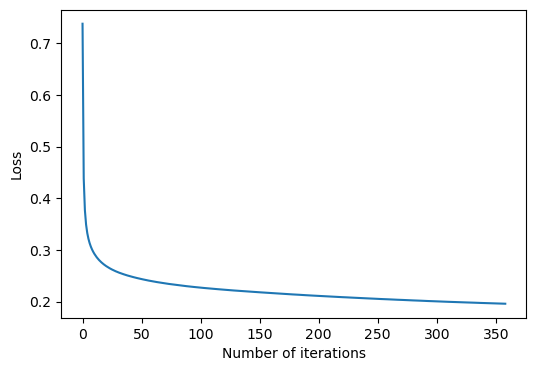

In [13]:
#plot training curve
import matplotlib.pyplot as plt
#plot loss over iterations
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(classifier.loss_curve_)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Loss')

print('Training accuracy: ', round(classifier.score(X_tr_norm, y_tr.flatten()),2))
print('Testing accuracy: ', round(classifier.score(X_test_norm, y_test.flatten()),2))

Text(0, 0.5, 'Validation')

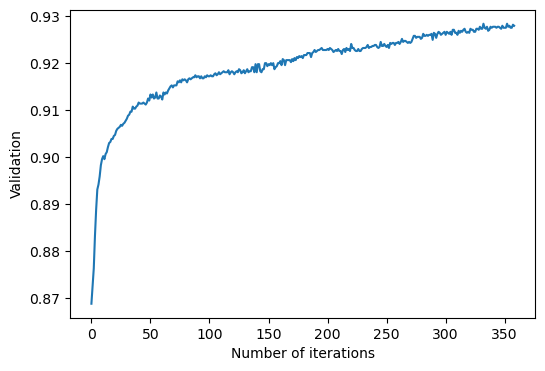

In [14]:
#plot validation curve
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(classifier.validation_scores_)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Validation')

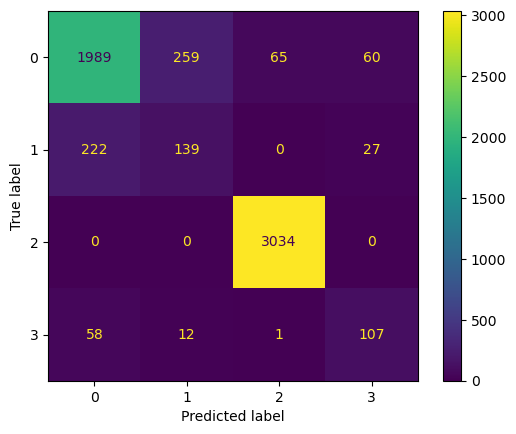

In [34]:
#plot confusion matrix to present performance
ConfusionMatrixDisplay.from_estimator(classifier, X_test_norm, y_test)

In [14]:
#search for optimal hyperparameters
parameters = {'hidden_layer_sizes': [(8,), (32,), (64,), (128,)],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'alpha': [0.0001, 0.001, 0.01],}

classifier2 = MLPClassifier(
                    solver='sgd',
                    learning_rate_init=1e-3,
                    max_iter=1000,
                    n_iter_no_change=25,
                    random_state=1,
                    early_stopping=True
)

search = GridSearchCV(classifier2, parameters, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
search.fit(X_tr_norm, y_tr)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=MLPClassifier(early_stopping=True, max_iter=1000,
                                     n_iter_no_change=25, random_state=1,
                                     solver='sgd'),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(8,), (32,), (64,), (128,)],
                         'learning_rate_init': [0.0001, 0.001, 0.01]},
             scoring='accuracy', verbose=2)

In [38]:
cv_results = search.cv_results_

# print(search.cv_results_)
data = pd.DataFrame(cv_results)#['param_hidden_layer_sizes','param_learning_rate_init','param_alpha', 'mean_test_score']
samplenames = ['param_hidden_layer_sizes','param_learning_rate_init','param_alpha', 'mean_test_score']
datasubset = data[samplenames]
display(datasubset)

,param_hidden_layer_sizes,param_learning_rate_init,param_alpha,mean_test_score
0,"(8,)",0.0001,0.0001,0.883958
1,"(8,)",0.001,0.0001,0.903288
2,"(8,)",0.01,0.0001,0.906018
3,"(32,)",0.0001,0.0001,0.889097
4,"(32,)",0.001,0.0001,0.906491
5,"(32,)",0.01,0.0001,0.908254
6,"(64,)",0.0001,0.0001,0.895504
7,"(64,)",0.001,0.0001,0.904771
8,"(64,)",0.01,0.0001,0.914296
9,"(128,)",0.0001,0.0001,0.898192


C:\Users\edsus\anaconda3\envs\mllabs\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


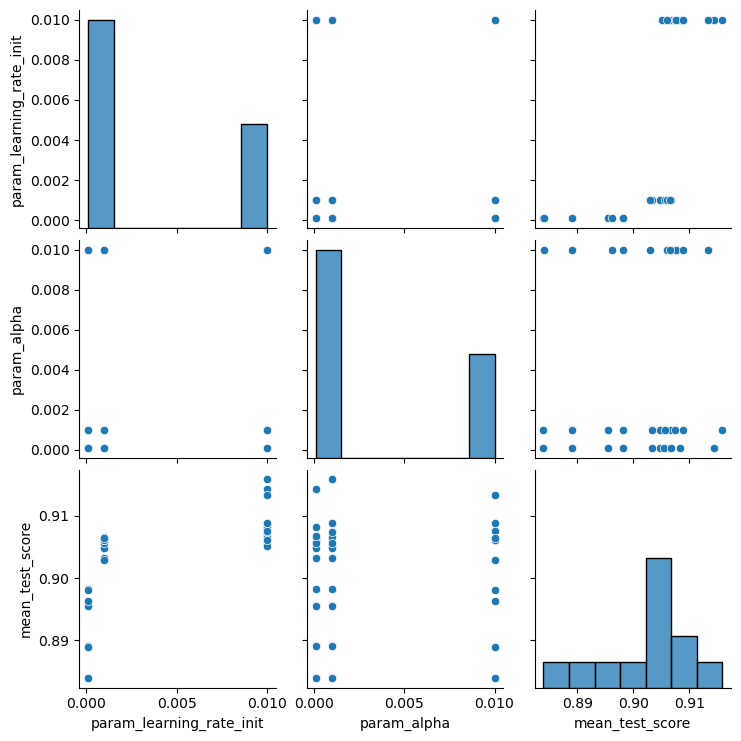

In [39]:
plot = sns.pairplot(datasubset)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

alphas = np.logspace(-3, -0, 100)
learning_rates = np.logspace(-4, -2, 100)
parameters = {'learning_rate_init':learning_rates, 'alpha':alphas}

nn = MLPClassifier(hidden_layer_sizes=(64),
                    activation='relu',
                    solver='sgd',
                    max_iter=1000,
                    n_iter_no_change=25,
                    random_state=1)

clf = RandomizedSearchCV(nn, parameters, scoring='accuracy', n_iter=10, cv=3, verbose=2)

clf.fit(X_tr_norm, y_tr.flatten())
clf.best_params_



In [ ]:
print('Training accuracy: ', round(clf.score(X_tr_norm, y_tr.flatten()),2))
print('Testing accuracy: ', round(clf.score(X_test_norm, y_test.flatten()),2))

In [ ]:
#plot loss over iterations
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(clf.loss_curve_)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Loss')

print('Training accuracy: ', round(clf.score(X_tr_norm, y_tr.flatten()),2))
print('Testing accuracy: ', round(clf.score(X_test_norm, y_test.flatten()),2))

## Task 1 - Part 2: Decision Tree

In [ ]:
#Task 2: decision tree
import sklearn
from sklearn.tree import DecisionTreeClassifier
import graphviz

model = DecisionTreeClassifier()
model.fit(X_tr_norm, y_tr)

print("Training set accuracy: {}".format(model.score(X_tr_norm, y_tr)))
print("Test set accuracy: {}".format(model.score(X_test_norm, y_test)))

In [ ]:
#visualise tree

# X_feature_names = input_cols
# y_target_names = output_col
# dot_data = sklearn.tree.export_graphviz(model, out_file=None, feature_names=X_feature_names, class_names=y_target_names, filled=True, rounded=True, special_characters=True)  
# graph = graphviz.Source(dot_data)
# graph.render("iris")
# display(graph)

In [ ]:
# count how many classifiers have voted for each class for each point in the test dataset.
def bagging_predict(test_data, all_models):
    votes = np.zeros((test_data.shape[0], len(all_models)))  # number of classes = 10.
    combined_predictions = np.zeros(test_data.shape[0])

    for idx, m in enumerate(all_models):
        # TODO
        # obtain the predictions from model m for the test data and
        # populate the votes vector
        votes[:, idx] = m.predict(test_data)
        
    for test_point in range(votes.shape[0]):
        # TODO
        # determine the class with the most votes for each test point
        # and populate the combined_predictions 
        # hint use np.bincount
        combined_predictions[test_point] = np.bincount(np.int64(votes[test_point])).argmax()
    
    return combined_predictions

num_models = 20
sample_size = 2000  # training set size.
np.random.seed(255)

all_models = []
for m in range(num_models):
    # Sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    sample_idx = np.random.choice(X_tr_norm.shape[0], sample_size)
    X_train_sample, y_train_sample = X_tr_norm[sample_idx], y_tr[sample_idx]
    
    model = DecisionTreeClassifier()
    
    # TODO
    # train a decision tree classifier on the random sample.
    model.fit(X_train_sample,y_train_sample)
    
    all_models.append(model)
    
prediction = bagging_predict(X_test_norm, all_models)
accuracy = np.count_nonzero(prediction==np.int64(y_test))/y_test.shape[0]
print("Test set accuracy: {}".format(accuracy))

In [ ]:
#Random Forest

num_models = 20
sample_size = 30000  # training set size.
feature_sample_size = 200
np.random.seed(255)

all_models = []
all_selected_features = []  # for each model, save the list of selected feature indexes.
for m in range(num_models):
    # TODO
    # copy in your code from the bagging exercise here to sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    # Hint: look at the documentation for numpy.random.choice().
    sample_idx = np.random.choice(X_tr_norm.shape[0], sample_size)
    X_train_sample, y_train_sample = X_tr_norm[sample_idx], y_tr[sample_idx]

    # TODO
    # create a decision tree classifier with limited features considered
    # for each split
    model = DecisionTreeClassifier(max_features=feature_sample_size)
    
    # TODO
    # copy in your code from the bagging exercise here to train a decision tree classifier on the random sample.
    # Remember to train it only on the random sample of features.
    model.fit(X_train_sample, y_train_sample)
    
    all_models.append(model)
    
prediction = bagging_predict(X_test, all_models)
accuracy = np.count_nonzero(prediction==np.int64(y_test))/y_test.shape[0]
print("Test set accuracy: {}".format(accuracy))


In [ ]:
#ensemble using adaboost


def boosting_predict(test_data, all_models, alphas):
    votes = np.zeros((test_data.shape[0], len(all_models))) 
    combined_predictions = np.zeros(test_data.shape[0])

    for idx, m in enumerate(all_models):
        # TODO
        # write your code here to obtain the predictions from model m and store it in votes.
        votes[:, idx] = m.predict(test_data)  
        
    
    for test_point in range(len(votes)):
        # TODO
        # determine the class with the most votes for each test point and store it in combined_predictions
        # hint: remember the weighting alpha
        combined_predictions[test_point] = np.bincount(np.int64(votes[test_point]), alphas).argmax()
    
    return combined_predictions

num_models = 200 # number of base classifiers
sample_size = 20000  # sample training set size.
np.random.seed(0)

# TODO
# initialise the sample weights for all data points in the training set.
sample_weights = np.ones(X_tr_norm.shape[0])/X_tr_norm.shape[0]

alphas = []
all_models = []
for m in range(num_models):
    # TODO
    # copy in your code from the bagging exercise here to sample with replacement from the training set. 
    # Each sample should contain sample_size data points chosen at random.
    # Hint: look at the documentation for numpy.random.choice().
    sample_idx = np.random.choice(X_tr_norm.shape[0], sample_size)
    X_train_sample, y_train_sample = X_tr_norm[sample_idx], y_tr[sample_idx]

    model = DecisionTreeClassifier(max_depth=10)
    # TODO
    # train a decision tree classifier on the weighted random sample.
    # Hint: fit() takes an additional argument, 'sample_weights'.
    model.fit(X_train_sample, y_train_sample, sample_weights[sample_idx])
    
    # TODO
    # compute the model error using weighted accuracy for the sampled training dataset
    # Hint: score() score takes an additional argument, 'sample_weight'.
    error = 1-model.score(X_train_sample, y_train_sample, sample_weights[sample_idx])

    # TODO
    # calculate alpha for the model and append alpha to alphas
    alpha = np.log((1-error)/error)
    alphas.append(alpha)
    
    # TODO
    # update the sample_weights for incorrect predictions using alpha
    incorrect_preds = model.predict(X_train_sample) != y_train_sample
    sample_weights[sample_idx] *= np.exp(alpha*incorrect_preds)
    
    all_models.append(model)
    
prediction = boosting_predict(X_test, all_models, alphas)
accuracy = np.count_nonzero(prediction==np.int64(y_test))/y_test.shape[0]
print("Test set accuracy: {}".format(accuracy))